# Plankton classification

STUDENT: 2481234b

In this exercise, we aim to train a deep-learning plankton classifier to accurately classify plankton images.

To achieve this, we will follow a set of basic steps. First, we will perform the basic setup, which includes installing the necessary libraries and setting up the environment. Next we will prepare the data by using the provided plankton data, which consists of approximately 1600 100x100 color images. In the Data Preparation section, we will describe how the training data will be augmented, address the problem of class imbalance, and other preprocessing techniques.

After preprocessing the data, we will create a deep-learning model. In this exercise, we will use the VGG16 pre-trained model for transfer learning and fine-tuning. We will train two versions of the model: 
1. freeze the convolutional layers and use them as feature extractors, and 
2. fine-tune the whole network.

Once we have trained the model, we will optimize the hyperparameters. To do this, we will use the Ax library to tune the parameters of the Adam optimizer. We will then serialize the best models.

Finally, we will evaluate the performance of the models. We will perform an evaluation of the models and display the results on the withheld test set. We will comment on the results and provide insights into the effectiveness of the deep-learning model for plankton classification.

## Setup

This section begins by importing the necessary libraries and defining utility functions that will be used to visualize and examine the dataset, as well as inspect the training progress and visualize the evaluation results.

In addition to defining these utility functions, a seed is set for the random number generators used by PyTorch to ensure that the results are replicable. The use of a GPU is also verified to accelerate calculations.

In [ ]:
# the model weights were too large to store on github, so they are uploaded on google drive
# to be able to downlad files from google drive, we need gdown
!pip3 install gdown
!pip3 install ax-platform 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# imports 
import gdown
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, random_split
from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from matplotlib.offsetbox import OffsetImage, AnchoredOffsetbox
from ax.service.managed_loop import optimize
from ax.utils.tutorials.cnn_utils import evaluate
from torchsummary import summary

import json
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm
from datetime import datetime
import copy
import pandas as pd

%matplotlib inline

In [ ]:
# utility functions

def get_inverse_mapping(dic):
  return {v:k for k, v in dic.items()}


def get_n_batches(data_loader, n=10):
  data_iter = iter(data_loader)
  return [next(data_iter) for _ in range(n)]


def visualize_batches(batches, class_names, order=None):
  samples = [np.bincount(t, minlength=len(class_names)) for _, t in batches]

  # batches in rows, calsses in columns, order columns by sum desc
  samples = np.array(samples)
  total_counts = samples.sum(axis=0)
  order = order if order is not None else np.argsort(-total_counts)
  samples = samples[:, order]
  total_counts = total_counts[order]

  class_names = np.array(class_names)[order]

  fig, ax = plt.subplots(figsize=(8,10))

  bottom = np.zeros(len(class_names))
  colors = sns.color_palette('hls', 12).as_hex()
  row_height = np.max(samples)+1
  col_width = 0.7

  for batch_id, class_dist in enumerate(samples):
      ax.bar(class_names, class_dist, col_width, bottom=bottom, color=colors)
      ax.text(-2.5, bottom[0]+row_height/2-1, f"Batch #{batch_id}")
      ax.axhline(bottom[0])
      bottom += row_height

  # write the totals
  ax.text(-2.5, bottom[0]+1, f"Totals:")
  for x, c in enumerate(total_counts):
    ax.text(x-0.25, bottom[0]+1, str(c))

  ax.set_title("class distribution in\nindividual training batches", pad=20)
  ax.set_yticks([])
  ax.tick_params(
      top=False,
      bottom=False,
      left=False,
      right=False,
      labelleft=False,
      labelbottom=True, 
      rotation=90
  )

  for key, spine in ax.spines.items():
      spine.set_visible(False)

  return fig, order


def show_img(img):
  plt.imshow(img)
  plt.axis('off')


def show_transforms(imgs, trfs, trf_names):
  im_size = 3
  fig, axs = plt.subplots(len(imgs), (len(trfs)+1), figsize=((len(trfs)+1)*im_size, len(imgs)*im_size))

  axs[0][0].set_title('Original')

  for i in range(len(imgs)):
    img=imgs[i]
    axs[i][0].imshow(img.numpy().transpose(1, 2, 0))
    axs[i][0].get_xaxis().set_visible(False)
    axs[i][0].get_yaxis().set_visible(False)

    for j in range(1, len(trfs)+1):
      if i==0: axs[0][j].set_title(trf_names[j-1])

      tr_img = trfs[j-1](img)
      tr_img = torch.clamp(tr_img, 0, 1)

      axs[i][j].imshow(tr_img.numpy().transpose(1, 2, 0))
      axs[i][j].get_xaxis().set_visible(False)
      axs[i][j].get_yaxis().set_visible(False)


def show_batch(imgs, class_names=None, denorm=None):
  fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16,16))
  axes = axes.flatten()

  # Loop through the images and plot them with their predicted class
  for i, image in enumerate(imgs):
    image = image.permute(1, 2, 0)

    # Denormalize the image and clip to 0-1, if applicable
    if denorm != None:
      mean, std = denorm
      image = (image * std) + mean
      image = torch.clamp(image, 0, 1)

    axes[i].imshow(image)
    if class_names != None:
      axes[i].set_title(class_names[i])
    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

    
def visualize_training(perf_log, title):
    train_acc, train_loss, val_acc, val_loss = perf_log
    n_epochs = len(train_acc)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(title)
    axes[0].plot(range(n_epochs), np.array(train_acc), label="Train")
    axes[0].plot(range(n_epochs), np.array(val_acc), label="Validation")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    
    axes[1].plot(range(n_epochs), np.array(train_loss), label="Train")
    axes[1].plot(range(n_epochs), np.array(val_loss), label="Validation")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    plt.tight_layout()


def evaluate_classification(model, test_loader, class_names):
    pred_classes = []
    true_classes = []
    confusion_matrix = torch.zeros(12, 12)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for true_cl, pred_cl in zip(classes.view(-1), preds.view(-1)):
                true_cl = true_cl.long().cpu()
                pred_cl = pred_cl.long().cpu()
                true_classes.append(true_cl)
                pred_classes.append(pred_cl)
                confusion_matrix[true_cl, pred_cl] += 1
    
    report = classification_report(true_classes, pred_classes, target_names=class_names)
    return confusion_matrix, report


def show_confusion_matrix(conf_m, model_name="", class_names=None, img_per_class=None):
    df_cm = pd.DataFrame(conf_m, class_names, class_names)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    sns.heatmap(df_cm, annot=True, square=True, cbar=False, annot_kws={"size": 16}, ax=ax)
    fig.suptitle("Confusion matrix "+model_name)
    
    if img_per_class is not None:
        plt.axis("off")
        for m, p in zip(img_per_class,range(12)):
            im = OffsetImage(m, zoom=0.2)
            xab = AnchoredOffsetbox(
                loc='upper left', 
                child=im, 
                bbox_to_anchor=(p-0.3,0), 
                bbox_transform=ax.get_xaxis_transform(),
                frameon=False
            )

            yab = AnchoredOffsetbox(
                loc='center right', 
                child=im, 
                bbox_to_anchor=(0,p+.5), 
                bbox_transform=ax.get_yaxis_transform(),
                frameon=False
            )
            ax.add_artist(xab)
            ax.add_artist(yab)

    plt.tight_layout()

    
def get_image_per_class():
    img_per_class = []
    for c in range(12):
        ix = torch.argwhere(plankton_data["labels"] == c)[0]
        img_per_class.append(plankton_data["images"][ix].squeeze().numpy().transpose(1, 2, 0))
    return img_per_class


def get_images_of_class(class_id):
    ixs = torch.argwhere(plankton_data["labels"] == class_id)
    imgs_of_class = [plankton_data["images"][ix].squeeze().numpy().transpose(1, 2, 0) for ix in ixs]
    return imgs_of_class

TRANSFERL_WTS_FNAME = "best_wts_transferl.pt"
FINETUNED_WTS_FNAME = "best_wts_finetuned.pt"
TRANSFERL_WTS_GDRIVE_ID = "1v_1nXpd1N-WzrAJpJ9LjB5xu10Mt4uVz"
FINETUNED_WTS_GDRIVE_ID = "1oucy56kBURKu3IUtFXK2l-WKVYY4NU2x"

In [ ]:
# additional setup
# download imagenet labels
!wget -nv -O "imagenet-simple-labels.json" "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
with open('imagenet-simple-labels.json') as f:
    imagenet_id_to_label = json.load(f)

# download model weights
gdown.download(id=TRANSFERL_WTS_GDRIVE_ID, output=TRANSFERL_WTS_FNAME, quiet=False)
gdown.download(id=FINETUNED_WTS_GDRIVE_ID, output=FINETUNED_WTS_FNAME, quiet=False)
    
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU acceleration: {torch.cuda.is_available()}")

2023-03-17 04:13:49 URL:https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json [14193/14193] -> "imagenet-simple-labels.json" [1]


Downloading...
From: https://drive.google.com/uc?id=1v_1nXpd1N-WzrAJpJ9LjB5xu10Mt4uVz
To: /content/best_wts_transferl.pt
100%|██████████| 537M/537M [00:03<00:00, 178MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oucy56kBURKu3IUtFXK2l-WKVYY4NU2x
To: /content/best_wts_finetuned.pt
100%|██████████| 537M/537M [00:02<00:00, 197MB/s]


GPU acceleration: True


## Data preparation

We have to prepare tha plankton data for the classification task. The general steps include:
1. Downloading the dataset and loading it into pytorch
2. Splitting it into a train/test and validation subsets (8:1:1)
3. Defining transformations to augment the dataset
3. Creating DataLoaders to be ble to fetch the data in mini-batches

### Loading the data

We start by loading the data. First, we download it, and then we create a pytorch dataset to be able to manipulate it further.

In [ ]:
!wget -nv --no-check-certificate "https://www.dropbox.com/s/v2udcnt98miwwrq/plankton.pt?dl=1" -O plankton.pt

plankton_data = torch.load('plankton.pt')
dataset = TensorDataset(plankton_data["images"], plankton_data["labels"])

2023-03-17 04:14:08 URL:https://uc61be8082e68c87d1fb3a5c0a09.dl.dropboxusercontent.com/cd/0/get/B4ZVomdCg4pEba-4lFwbipPvVvSNM-Dw2Xy83avCcXcbqImSbT7kXbGxWCKBMUYPOmlHlXLqO77yXaD0TMnwTSvUSSW5AQMiUW6KyUjQsAdm8FmTp561K5LNTSJaROn48RelOMFYOwylKil1AJkGFJ3HqLHZZL_5H2knJfS6A51rSw/file?dl=1 [194047719/194047719] -> "plankton.pt" [1]


In [ ]:
class_ids = plankton_data["labels"].unique()
class_names = list(plankton_data['names'].keys())
class_name_to_id = plankton_data['names']
class_id_to_name = get_inverse_mapping(class_name_to_id)

### Splitting into train/test/validation subsets

We continue by partitioning the data into three subsets: training, validation, and testing. The training subset will be utilized to train the model, the validation subset will be used for hyperparameter optimization and to prevent overfitting, and the testing set for the final evaluation. The code also outputs the relative sizes of the subsets in terms of the number of samples in each. 

(Although an alternative approach would be to utilize cross-validation for training and hyperparameter optimization and a separate held-out test set for final evaluation, we have opted for a slightly simpler approach.)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size

# split the dataset into train, test, and validation subsets
train_set, test_set, val_set = random_split(dataset, [train_size, test_size, val_size])

# show dataset sizes & class imabalnce
print("\n".join(map(" ".join, zip(("train:", "test:", "validation:"), map(str, [train_size, test_size, val_size])))))

train: 1293
test: 161
validation: 163


### Data augmentation and normalization

Given the limited number of samples in the dataset, we decided to augment it using online data augmentation techniques to artificially increase the size of the dataset and prevent overfitting. This is particularly useful when dealing with imbalanced datasets where some classes have very few examples.

We decided to use _online_ data augmentation instead of _offline_ augmentation, where we would generate augmented images beforehand and store them in a separate directory. This is because online data augmentation allows us to generate new images on-the-fly during training, which can help the model generalize better to new, unseen images.

To prevent information leakage, we perform the dataset transformations after splitting the data into training, testing, and validation subsets. This ensures that the training data does not contain any information from the testing or validation data, which could lead to overfitting. For example, if we augumented a dataset using a rotation transformation, the dataset would contain both - the original and the rotated version of an image. If we then randomly split the dataset into training, testing, and validation then it could easily happen that the origianl image would end up in the training set, while the rotated version in the test or validation set, which would bias results. Online augmentation also helps to prevent this.

It is also important to keep the testing and validation data as unchanged as possible, while the training data might benefit from more aggressive transformations. This is because the testing and validation data should reflect the real-world data that the model will encounter, while the training data can be augmented to improve the model's ability to generalize.

For the training set, we decided to use a combination of random rotation (0-180 degrees), horizontal flip, vertical flip, and random crop to help the model learn different features from different perspectives. We also resize the image to 244x244 pixels. We hope that using rotation as transformation may, for example, teach the model to ignore the black/white boundary present at the edges of the images and prevent it from overfitting on the image orientation. For the test and validation sets, we applied only resizing to 256 pixels and a center crop to 244 to preserve the original image as much as possible.

In addition to data augmentation, we also applied normalization to the data to ensure that the pixel values have similar ranges and are centered around zero. We used the mean and standard deviation of the training set to normalize the pixel values of all the subsets.

In PyTorch, these transformations can be performed using the `torchvision.transforms` module. However, because the training, testing, and validation sets are instances of the `Subset` class, which only stores information about the indices of items from an underlying dataset that belong to that particular subset, we defined our own `DatasetFromSubset` class to apply custom transformations to each subset of the original dataset.

In [ ]:
# this class is based on
# https://discuss.pytorch.org/t/torch-utils-data-dataset-random-split/32209/4

from torch.utils.data import Dataset

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In order to be able to apply Normalization to the data, we need to pre-compute the mean and standard deviation of the three color channels in the training dataset. Then, we will use the same values for the testing and validation subsets, in order to prevent information leakage and ensure that the model is generalizing to new, unsen data.

In [ ]:
train_mean = plankton_data["images"][train_set.indices].mean(axis=(0,2,3))
train_std = plankton_data["images"][train_set.indices].std(axis=(0,2,3))

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(contrast=0.2, saturation=0.5, brightness=0.2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Normalize(train_mean, train_std)
    ])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(train_mean, train_std)
    ])

val_transforms = test_transforms

train_dataset = DatasetFromSubset(train_set, transform=train_transforms)
test_dataset = DatasetFromSubset(test_set, transform=test_transforms)
val_dataset = DatasetFromSubset(val_set, transform=val_transforms)

We can visualize the transformations applied to the images:

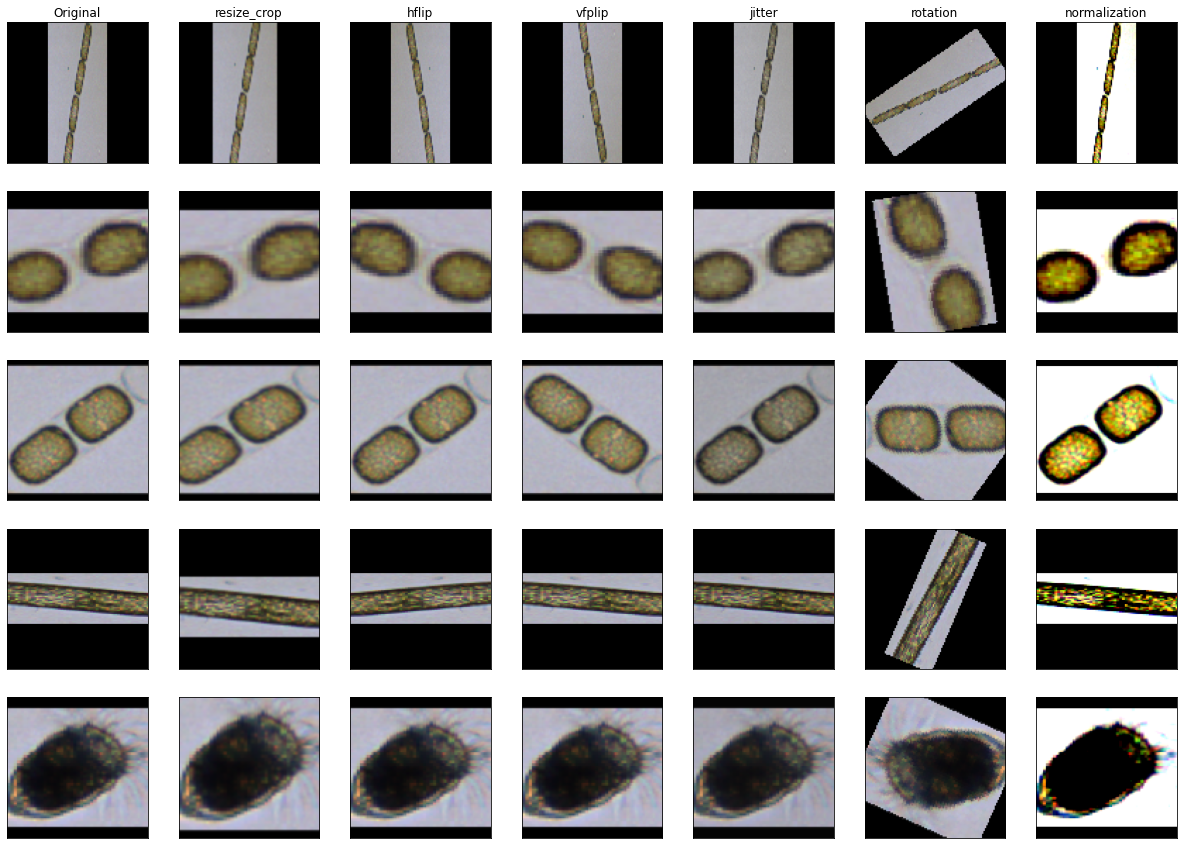

In [ ]:
trfs = [
    transforms.RandomResizedCrop(224, scale=(0.8,1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(contrast=0.2, saturation=0.5, brightness=0.2),
    transforms.RandomRotation(degrees=(0, 180)),
    transforms.Normalize(train_mean, train_std)
    ]

names = ["resize_crop", "hflip", "vfplip", "jitter", "rotation", "normalization"]

imgs = dataset[[10, 50, 100, 150, 200]][0]

show_transforms(imgs, trfs, names)


### Class Imbalance - weighted sampling

We can observe the relative distributions of classes in each mini-batch on the chart below:

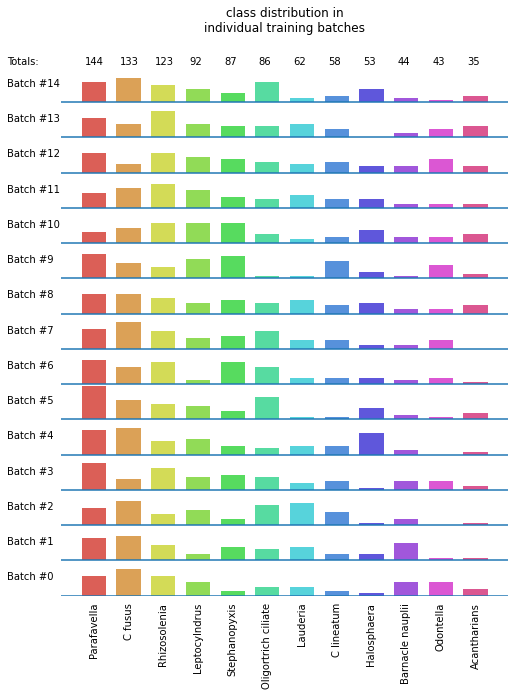

In [ ]:
unbalanced_train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

batches = get_n_batches(unbalanced_train_loader, 15)
fig, order = visualize_batches(batches, class_names)

Even though the data is augmented, it is not enough to ensure equal representation of all classes in the mini-batches. Some classes, such as _Parafavella_, are overrepresented, while others, like _Acantharians_, are underrepresented. This class imbalance can have a negative effect on the training process, as the model might not learn to distinguish well between the underrepresented classes. 

To mitigate this issue, we use a `WeightedRandomSampler`, which samples mini-batches with probability proportional to the inverse of the class frequency. This means that the underrepresented classes will be sampled more frequently and will have a larger representation in the mini-batches than in the original dataset, while the opposite holds for the overrepresented classes. 

In this way, the model observes approximately the same distribution of all classes in each mini-batch, which helps to prevent the model from being biased towards any specific class. This is important since the relative concentrations of the different classes in the mini-batches can impact the performance of the model on specific species.

It is important to only balance the training set and keep the validation and test sets with their original class distributions, because we want to evaluate the model's performance on data that is representative of the real-world distribution of the classes. If we balance the validation and test sets as well, we may end up with an unreliable estimate of the model's performance.

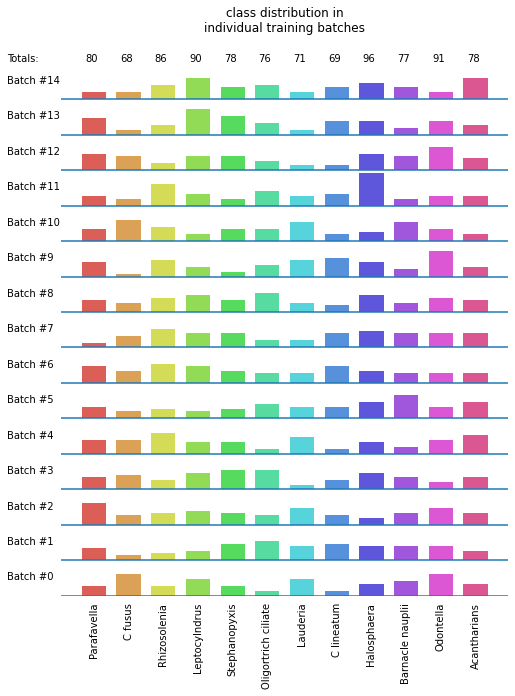

In [ ]:
# Create weighted sampler for train subset
train_labels = dataset.tensors[1][train_dataset.subset.indices]
class_counts_train = np.bincount(train_labels)
class_weights_train = 1.0 / torch.Tensor(class_counts_train)
sample_weights = class_weights_train[train_labels.numpy()]
train_sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

# Create DataLoader objects for the train, test, and validation subsets
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)

batches = get_n_batches(train_loader, 15)
fig, _ = visualize_batches(batches, class_names, order=order)
fig.show()

We can see that there is no particular bias in the number of samples of each classs in the mini-batches. 

We can also define the DataLoaders for the testing and validation subsets. This time, without using the weighted sampler. To ensure fair evaluation conditions, the class distribution on these datasets has to represent a real-world scenario. Balancing could lead to results that would not generalize into the real world. 

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

## Create the Model

Now, we can create the model. In our case, we chose to use a pre-trained VGG16 model available from PyTorch as a suitable candidate. One of the reasons for this choice is the small size of our dataset. Training a similar convolutional neural network (CNN) from scratch on such a small dataset might lead to overfitting, since the model could potentially memorize the training set. A smaller network could, on the other hand, simply have too few parameters to achieve a good performance. Transfer learning is a technique that has proven effective in situations with limited data.

Transfer learning involves using a pre-trained neural network model on a larger dataset as a starting point and then fine-tuning the model on the smaller dataset. The intuition behind this approach is that the lower-level features learned by the pre-trained model on the larger dataset can be useful for the smller dataset as well. Therefore, we can use the pre-trained VGG16 model as a feature extractor and then only train the dense claassification layers to adapt it to our specific task of species classification. This allows us to benefit from the pre-trained model's knowledge, while only training a smaller number of parameters on our own dataset.

Below is a summary of the basic VGG16 architecture.

In [ ]:
vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
summary(vgg16_model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

For fun, we can 'test' the pre-trained model on one batch of our plankton dataset - what does it 'think' the images in our dataset correspond to? 

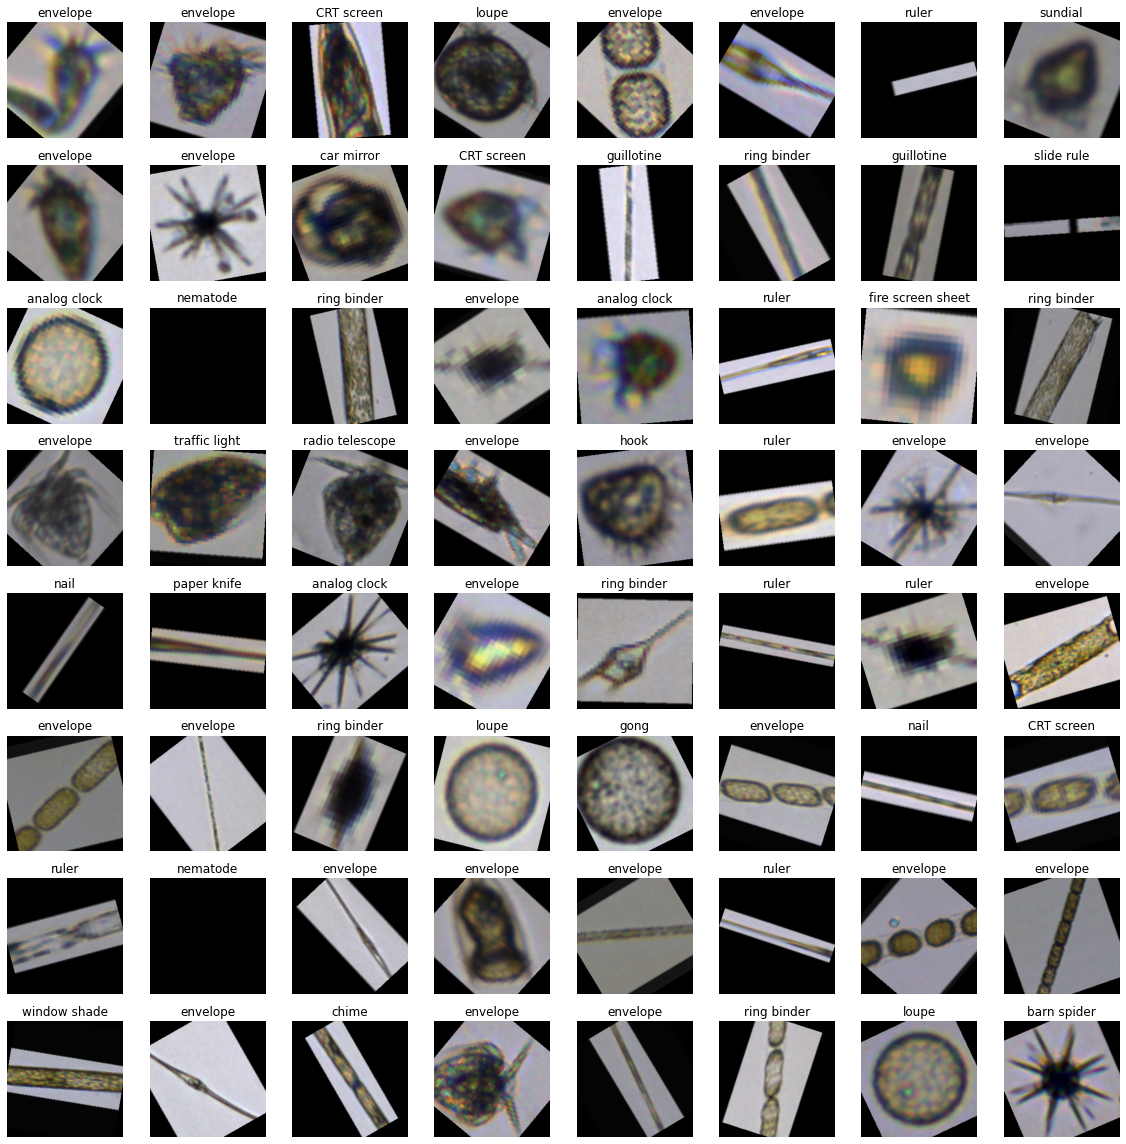

In [ ]:
images, labels = next(iter(train_loader))
images = images.to(device)
vgg16_model.to(device)
vgg16_model.eval()

with torch.no_grad():
    predictions = vgg16_model(images)

_, predicted_classes = torch.max(predictions, 1)
labels = [imagenet_id_to_label[class_id] for class_id in predicted_classes]

show_batch(images.to('cpu'), labels, denorm=(train_mean, train_std))

Not the best for our task, but still relatively impressive: envelopes, ring binders, gongs, rulers, flutes, scews,...
The model has never seen images of plankton, so this result is expected. Notably, the model probably doesn't yet know that in our dataset, the boundary between the black and white is not part of the actual image, but both of those are background that should be ignored. Hence, for example, the 'envelope' or 'ruler' labels.

### Training

In this section, we will use the pre-trained VGG16 model to build two different models. Fistly we will use it for transfer learning (as a feature extractor), and then we will fine-tune it to our classification task. Then we will compare the performace of these two models in the Evaluation section.

We define our training and testing loops in a realtively standard way. The training loop also evaluates the model against a validation set after each epoch. This is done to be able to choose the model with the best performance on the validataion set as our "best model" and to verify that the model generalizes to unseen data rather than simply overfitting the training data.

In [ ]:
def training_loop(n_epochs, optimizer, model, device, loss_fn, train_loader, quiet=False):
    model.train()
    model = model.to(device)
    
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    best_vacc = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in tqdm(range(1, n_epochs + 1)):
        epoch_loss = 0.0
        correct = 0
        for imgs, class_ids in train_loader:
            outputs = model(imgs.to(device))
            loss = loss_fn(outputs, class_ids.long().to(device))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            pred = outputs.argmax(dim=1, keepdim=True)
            correct += pred.eq(class_ids.to(device).view_as(pred)).sum().item()
        
        acc = correct / len(train_loader.dataset)
        epoch_loss = epoch_loss/len(train_loader)
        train_loss.append(epoch_loss)
        train_acc.append(acc)
        
        if not quiet:
            print(f"{datetime.now()} Epoch {epoch}/{n_epochs}")
            print(f"Training loss: {float(epoch_loss):.2f} accuracy: {correct}/{len(train_loader.dataset)} ({100. * acc :.0f}%)")
            print("Validation", end=" ")
            
        vloss, vacc = test_loop(model, device, loss_fn, val_loader, quiet=quiet)
        if vacc > best_vacc:
            best_model_wts = copy.deepcopy(model.state_dict())
            
        val_loss.append(vloss)
        val_acc.append(vacc)
    
    return best_model_wts, (train_acc, train_loss, val_acc, val_loss)

In [ ]:
def test_loop(model, device, loss_fn, test_loader, quiet=False):
    model.eval()
    model = model.to(device)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for imgs, class_ids in test_loader:
            output = model(imgs.to(device))
            loss = loss_fn(output, class_ids.long().to(device))

            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(class_ids.to(device).view_as(pred)).sum().item()

    test_loss = test_loss/len(test_loader)
    acc = correct / len(test_loader.dataset)
    if not quiet:
        print(f'loss: {test_loss:.4f} accuracy: {correct}/{len(test_loader.dataset)} ({100. * acc:.0f}%)\n')
    return test_loss, acc

### Transfer learning
Transfer learning is our first approach in this project. We start by freezing all the convolutional layers responsible for feature extraction. We do so because we assume that these layers have already been optimized to respond to different higher-order structures on images. Subsequently, we replace the last layer of the classifier to fit the required output dimension, which in our case is 12 classes rather than the original 1000. 

Finally, we train only these last fully connected layers that form the classifier.

In [ ]:
%%script echo "skip"

# Freeze training for all feature layers
for param in vgg16_model.features.parameters():
    param.requires_grad = False

vgg16_model.classifier[-1] = nn.Linear(4096, 12)

skip


We can make sure that we really disabled the backpropagation for the convolutional layers and that we will just train the classifier. We also make sure that the classifier has the right output dimension.

In [ ]:
%%script echo "skip"

params_to_update = []
for name, param in vgg16_model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        params_to_update.append(param)

skip


During training, we will use a learning rate of 0.0001 with the Adam optimizer, and apply the cross-entropy loss function. Given that the task at hand involves multi-class classification, the selected loss function is suitable for this purpose. We will train for 100 epochs.

In [ ]:
%%script echo "skip"

lr = 0.0001
optimizer = Adam(params_to_update, lr=lr)
loss_fn = nn.CrossEntropyLoss()

skip


In [ ]:
%%script echo "skip"

# train the model
n_epochs = 100
best_model_wts_transferl, perf_log_transferl = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = vgg16_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

skip


We can now visualize the training progress:

In [ ]:
%%script echo "skip"

visualize_training(perf_log_transferl, "Transfer learning training progress")

skip




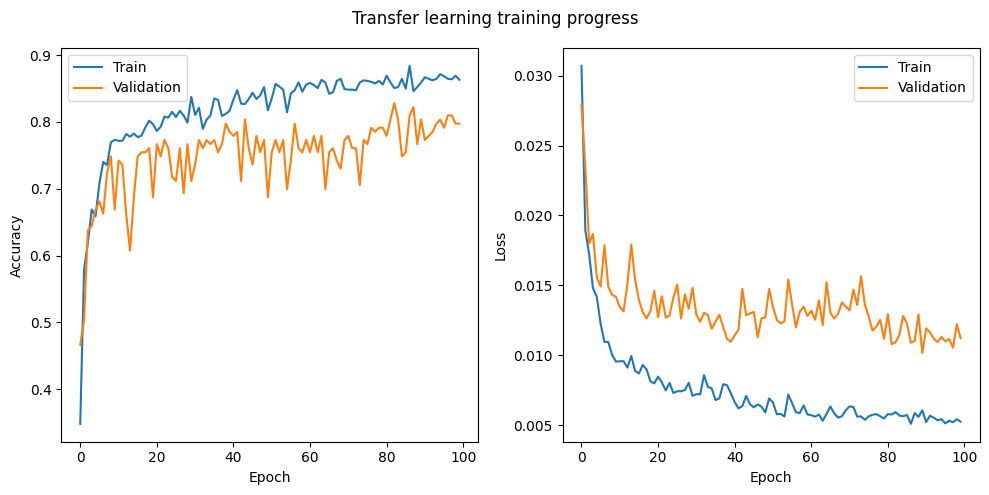

### Fine-tuning

Fine-tuning the whole model to our specific task is an alternative approach to using the pre-trained convolutional layers only as a feature extractor. In contrast to the previous approach, this method enables the adjustment of the feature weights during backpropagation.

The pre-trained convolutional layers have learned representations of visual patterns in images in order to perform well on the diverse ImageNet dataset. The early layers of the network learned to recognize colors, simple patterns, edges, or textures, while the later layers learned combinations of these patterns to represent more complex higher-level shapes or objects. However, some of the higher-level features learned on the ImageNet dataset might not be useful for our specific plankton classification task.

By enabling backpropagation throughout the whole network, the model will be able to improve the feature extraction process to learn features that are more useful for plankton classification. We hypothesize that fine-tuning the model in this way will lead to improved classification accuracy on the plankton dataset.

To fine-tune the model, we will replace the last layer of the classifier with a 4096x12 linear layer to reflect the fact that we have only 12 classes to classify. Unlike the previous approach, gradient calculations will be enabled for the whole network.

In [ ]:
%%script echo "skip"

vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
vgg16_model.classifier[-1] = nn.Linear(4096, 12)

skip


We proceed by initializing the optimizer and loss function in the same way as before, with the exception that this time we pass to the optimizer all of the network's parameters rather than just the classifier layer.

In [ ]:
%%script echo "skip"

lr = 0.0001
optimizer = Adam(vgg16_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

skip


In [ ]:
%%script echo "skip"

n_epochs = 100
best_model_wts_finetuned, perf_log_finetuned = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = vgg16_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)


skip


In [ ]:
%%script echo "skip"

visualize_training(perf_log_finetuned, "Fine-tuning training progress")

skip


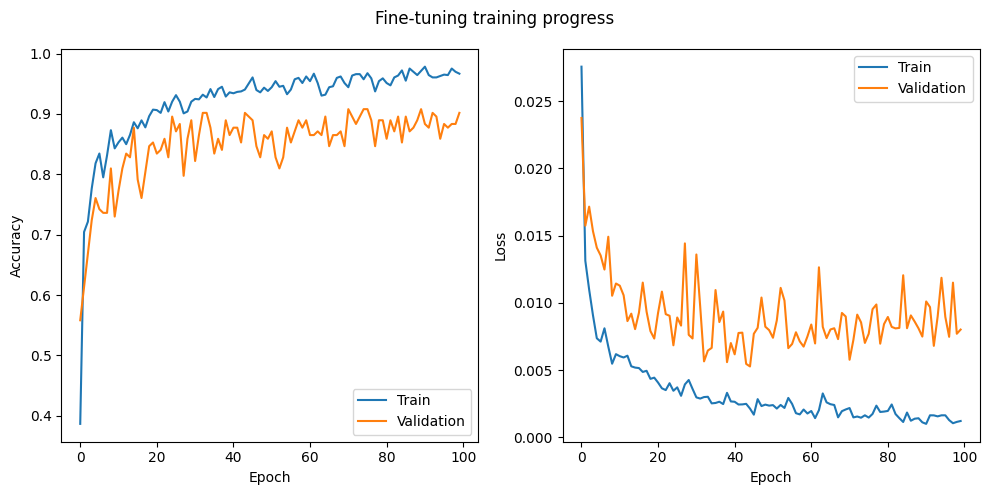

We were able to achieve a validation accuracy of around 90% with our model. 

However, it is worth noting that the training and validation loss start to diverge after around 30-50 epochs, indicating that the model is starting to over-fit. This behavior is similar to what was observed during the training of the pure transfer learning model. This information is useful because it allows us to set a reasonable maximum number of epochs during hyper-parameter tuning to avoid over-fitting and save time and resources.

### Hyper-parameter optimization

We will optimize "learning rate" and "AMSGrad" hyper-parameters of the Adam optimizer using the `Ax` framework. We will train 20 models for 40 epochs and obtain the best set of hyperparameters.

In [ ]:
def train_evaluate(parameterization):
    # create a new model and train it for 40 epochs
    vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
    vgg16_model.classifier[-1] = nn.Linear(4096, 12)
    
    lr, amsgrad = parameterization["lr"], parameterization["amsgrad"]
    
    wts, perf_log = training_loop(
        n_epochs = 40, 
        optimizer = Adam(vgg16_model.parameters(), lr=lr, amsgrad=amsgrad),
        model = vgg16_model, 
        device = device,
        loss_fn = nn.CrossEntropyLoss(),
        train_loader = train_loader,
        quiet=True
    ) 
    
    vgg16_model.load_state_dict(wts)
    
    result = evaluate(
        net=vgg16_model,
        data_loader=val_loader,
        dtype=torch.float,
        device=device,
    )
    
    return result

In [ ]:
%%script echo "skip"

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "amsgrad", "type": "choice", "values": [True, False]},
    ],
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

skip


In [ ]:
%%script echo "{'lr': 8.921052340378907e-05, 'amsgrad': True} (skip)"

best_parameters

{'lr': 8.921052340378907e-05, 'amsgrad': True} (skip)


The best parameters were found to be `lr=0.000089`, which is very close to what we've trained the model with earlier, and `amsgrad=True`, which we haven't tried before. We will train the model with these parameters now:

In [ ]:
%%script echo "skip"

vgg16_model = vgg16(weights=VGG16_Weights.DEFAULT)
vgg16_model.classifier[-1] = nn.Linear(4096, 12)

optimizer = Adam(
    vgg16_model.parameters(), 
    lr=best_parameters["lr"], 
    amsgrad=best_parameters["amsgrad"]
)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 60
best_model_wts_finetuned, perf_log_finetuned = training_loop(
    n_epochs = n_epochs, 
    optimizer = optimizer,
    model = vgg16_model, 
    device = device,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

skip


In [ ]:
%%script echo "skip"

visualize_training(perf_log_finetuned, "Fine-tuning training progress")

skip


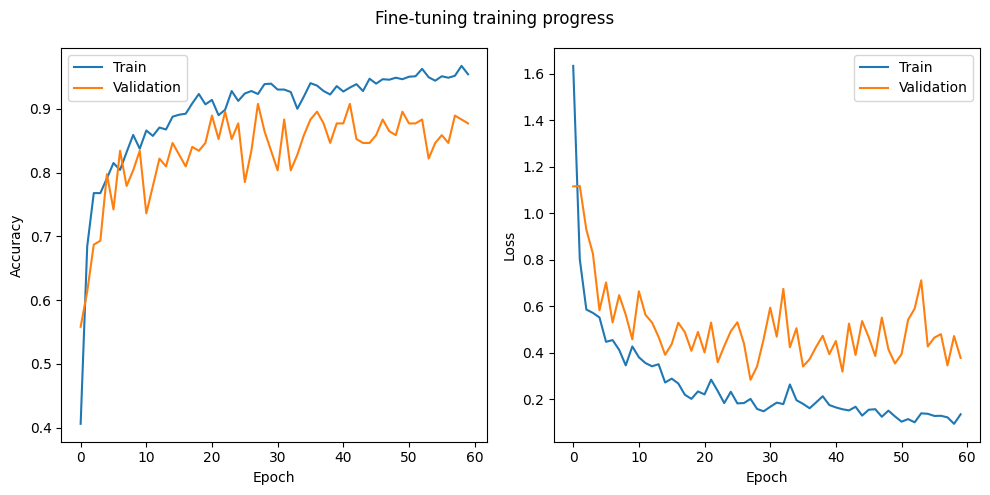

### Serializing the best models

We saved the best parameters (in terms of validation accuracy) for each model during training. Now we can serialize those for later use.

In [ ]:
%%script echo "skip"

torch.save(best_model_wts_transferl, TRANSFERL_WTS_FNAME)
torch.save(best_model_wts_finetuned, FINETUNED_WTS_FNAME)

skip


### Loading the best models
We load the saved (or downloaded) model weights and use them to initialize models.

In [ ]:
best_model_wts_transferl = torch.load(TRANSFERL_WTS_FNAME)
best_model_wts_finetuned = torch.load(FINETUNED_WTS_FNAME)

In [ ]:
# initialize both models
# the architecture has to match the weights
best_model_finetuned = vgg16()
best_model_finetuned.classifier[-1] = nn.Linear(4096, 12)
best_model_transferl = vgg16()
best_model_transferl.classifier[-1] = nn.Linear(4096, 12)

# load the weights
best_model_finetuned.load_state_dict(best_model_wts_finetuned)
best_model_finetuned = best_model_finetuned.to(device)
best_model_transferl.load_state_dict(best_model_wts_transferl)
best_model_transferl = best_model_transferl.to(device)

## Evaluation

Finally, we evaluate the preformance of our models on the test set in terms of loss and prediction accuracy.

In [ ]:
print("Transfer learning performance on the test set")
test_loop(
    model = best_model_transferl, 
    device = device,
    loss_fn = nn.CrossEntropyLoss(),
    test_loader = test_loader
)

print("Fine-tuned model performance on the test set")
# and test again to see any improvement
_ = test_loop(
    model = best_model_finetuned, 
    device = device,
    loss_fn = nn.CrossEntropyLoss(),
    test_loader = test_loader
)

Transfer learning performance on the test set
loss: 0.5105 accuracy: 129/161 (80%)

Fine-tuned model performance on the test set
loss: 0.2317 accuracy: 145/161 (90%)



We can see that, indeed, the fine-tuned model performs radically better (90% acc.) than the one that was trained with frozen convolutional layer weights (80% acc.)
Additionally, we can visualize a confusion matrix and display the classification report for both models:

                     precision    recall  f1-score   support

      Stephanopyxis       0.79      0.92      0.85        12
          Odontella       1.00      0.75      0.86         4
        Parafavella       1.00      0.90      0.95        31
           Lauderia       0.62      0.62      0.62        13
   Barnacle nauplii       0.86      1.00      0.92         6
       Acantharians       1.00      1.00      1.00         8
         C lineatum       0.86      0.86      0.86         7
       Rhizosolenia       0.77      0.71      0.74        28
            C fusus       0.75      0.79      0.77        19
        Halosphaera       1.00      1.00      1.00         3
      Leptocylndrus       0.56      0.53      0.54        19
Oligortrich ciliate       0.79      1.00      0.88        11

           accuracy                           0.80       161
          macro avg       0.83      0.84      0.83       161
       weighted avg       0.80      0.80      0.80       161



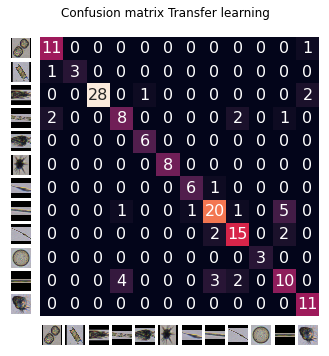

In [ ]:
cnf_matrix, report = evaluate_classification(best_model_transferl, test_loader, class_names)

print(report)
img_per_class = get_image_per_class()
show_confusion_matrix(cnf_matrix.numpy(), model_name="Transfer learning", img_per_class=img_per_class)

                     precision    recall  f1-score   support

      Stephanopyxis       1.00      1.00      1.00        12
          Odontella       0.80      1.00      0.89         4
        Parafavella       1.00      0.97      0.98        31
           Lauderia       1.00      1.00      1.00        13
   Barnacle nauplii       1.00      1.00      1.00         6
       Acantharians       1.00      1.00      1.00         8
         C lineatum       0.88      1.00      0.93         7
       Rhizosolenia       0.78      0.75      0.76        28
            C fusus       0.86      1.00      0.93        19
        Halosphaera       1.00      1.00      1.00         3
      Leptocylndrus       0.73      0.58      0.65        19
Oligortrich ciliate       0.92      1.00      0.96        11

           accuracy                           0.90       161
          macro avg       0.91      0.94      0.92       161
       weighted avg       0.90      0.90      0.90       161



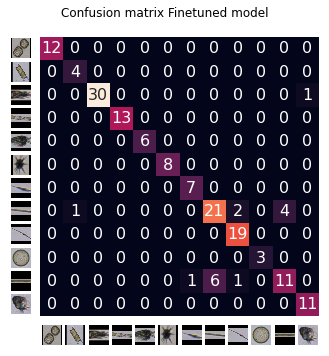

In [ ]:
cnf_matrix, report = evaluate_classification(best_model_finetuned, test_loader, class_names)
print(report)
show_confusion_matrix(cnf_matrix.numpy(), model_name="Finetuned model", img_per_class=img_per_class)

The fine-tuned model showed impressive ability to differentiate between different plankton species, with an exception of two classes: _Rhizosolenia_ and _Leptocylndrus_. These two classes were still difficult to differentiate for both the fine-tuned and transfer learning models, as they both appear as straight sticks without any distinguishable features or colors. The lowest F1 scores of the fine-tuned model were reported for these classses: 0.76 and 0.65, respectively.

However, the fine-tuned model showed significant improvements in some problematic classes that were difficult for the transfer learning model. One notable example is the class _Lauderia_, which had the second-worst F1 score of 0.62 in the transfer learning model. The fine-tuned model achieved an F1 score of 1.0 on the same class, which represents a significant improvement. 

Furthermore, the transfer learning model often confused _Leptocylndrus_ and _Lauderia_ species, but the fine-tuned model showed improved performance on _Lauderia_ and a beneficial effect on the other classes that were previously confused with it. This could be attributed to the fact that the fine-tuned model was allowed to adjust the feature parameters and learn features that are more helpful in distinguishing between these problematic classes.

Lastly, it's worth noting that the fine-tuned model had better performance than the transfer learning model for all classes and with respect to every considered metric.